### Build a simple Neural Network on SVHN dataset

#### Import the data from drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Open the file as readonly

h5f = h5py.File('/content/drive/My Drive/DLCP/Project-1/Data/SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
x_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()

x_train = x_train.reshape(x_train.shape[0], 1024)
x_test = x_test.reshape(x_test.shape[0], 1024)

# # normalize inputs from 0-255 to 0-1
x_train = x_train / 255.0
x_test = x_test / 255.0

print('Training set', x_train.shape, y_train.shape)
print('Test set', x_test.shape, y_test.shape)

('Training set', (42000, 1024), (42000,))
('Test set', (18000, 1024), (18000,))


In [0]:
print(x_train.shape)
print(y_train.shape)

(42000, 1024)
(42000,)


In [0]:
print(x_test.shape)
print(y_test.shape)

(18000, 1024)
(18000,)


### Neural network from scratch

#### Fully Connected Layer (Linear Layer)

In [0]:
# Fully Connected Layer

class Linear():
  """
  Fully Connected Layer
  """
  def __init__(self, input_size, output_size):
    self.W = np.random.randn(input_size, output_size) * 0.01 # random weights
    self.b = np.zeros((1, output_size)) # random bias
    self.params = [self.W, self.b] # list of parameters
    self.gradW = None # gradient of weights
    self.gradB = None # gradient of bias
    self.gradInput = None
  
  def forward(self, X):
    self.X = X
    # output = X.W + b
    self.output = np.dot(X, self.W) + self.b
    return self.output
  
  def backward(self, nextgrad):
    self.gradW = np.dot(self.X.T, nextgrad) # gradW = transpose(X).nextgrad
    self.gradB = np.sum(nextgrad, axis=0)
    self.gradInput = np.dot(nextgrad, self.W.T)
    return self.gradInput, [self.gradW, self.gradB]

#### Rectified Linear Activation Layer (ReLU)


In [0]:
class ReLU():
  """
  Rectified Linear Activation Layer (ReLU)
  """
  def __init__(self):
    self.params = [] # list of parameters
    self.gradInput = None

  def forward(self, X):
    # relu(x) = np.max(0, x)
    self.output = np.maximum(X, 0)
    return self.output

  def backward(self, nextgrad):
    self.gradInput = nextgrad.copy()
    self.gradInput[self.output <=0] = 0
    return self.gradInput, []

#### Define softmax function

In [0]:
class Softmax():
  """
  Softmax Activation Function
  """
  def __init__(self):
    self.params = []
    self.gradInput = None

  def forward(self, X):
    exp_x = np.exp(X - np.max(X, axis=1, keepdims=True))
    self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return self.output

  def backward(self, nextgrad):
    self.gradInput = nextgrad.copy()
    self.gradInput[self.output <=0] = 0
    return self.gradInput, []

#### Define the Cross Entropy Loss

In [0]:
class CrossEntropy:
  def forward(self, X, y):
    self.m = y.shape[0]
    self.p = softmax(X)
    cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
    loss = np.sum(cross_entropy) / self.m
    return loss

  def backward(self, X, y):
    y_idx = y.argmax()        
    grad = softmax(X)
    grad[range(self.m), y] -= 1
    grad /= self.m
    return grad

#### Define the container NN class that enables the forward prop and backward propagation of the entire network. Note, how this class enables us to add layers of different types and also correctly pass gradients using the chain rule.

In [0]:
class NN():
  def __init__(self, lossfunc=CrossEntropy(), mode='train'):
    self.params = []
    self.layers = []
    self.loss_func = lossfunc
    self.grads = []
    self.mode = mode

  def add_layer(self, layer):
    self.layers.append(layer)
    self.params.append(layer.params)

  def forward(self, X):
    for layer in self.layers:
        X = layer.forward(X)
    return X

  def backward(self, nextgrad):
    self.clear_grad_param()
    for layer in reversed(self.layers):
        nextgrad, grad = layer.backward(nextgrad)
        self.grads.append(grad)
    return self.grads

  def train_step(self, X, y):
    out = self.forward(X)
    loss = self.loss_func.forward(out,y)
    nextgrad = self.loss_func.backward(out,y)
    grads = self.backward(nextgrad)
    return loss, grads

  def predict(self, X):
    X = self.forward(X)
    p = softmax(X)
    return np.argmax(p, axis=1)

  def predict_scores(self, X):
    X = self.forward(X)
    p = softmax(X)
    return p

  def clear_grad_param(self):
    self.grads = []

#### Define the update function (SGD with momentum)

In [0]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
  for v, p, g, in zip(velocity, params, reversed(grads)):
    for i in range(len(g)):
      v[i] = mu * v[i] - learning_rate * g[i]
      p[i] += v[i]

#### Define a function which gives us the minibatches (both the datapoint and the corresponding label)

In [0]:
# get minibatches
def minibatch(X, y, minibatch_size):
  n = X.shape[0]
  minibatches = []
  permutation = np.random.permutation(X.shape[0])
  X = X[permutation]
  y = y[permutation]

  for i in range(0, n , minibatch_size):
    X_batch = X[i:i + minibatch_size, :]
    y_batch = y[i:i + minibatch_size, ]
    minibatches.append((X_batch, y_batch))

  return minibatches

#### The traning loop

In [0]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None):
  val_loss_epoch = []
  minibatches = minibatch(X_train, y_train, minibatch_size)
  minibatches_val = minibatch(X_val, y_val, minibatch_size)


  for i in range(epoch):
      loss_batch = []
      val_loss_batch = []
      velocity = []
      for param_layer in net.params:
          p = [np.zeros_like(param) for param in list(param_layer)]
          velocity.append(p)

      # iterate over mini batches
      for X_mini, y_mini in minibatches:
          loss, grads = net.train_step(X_mini, y_mini)
          loss_batch.append(loss)
          update_params(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

      for X_mini_val, y_mini_val in minibatches_val:
          val_loss, _ = net.train_step(X_mini, y_mini)
          val_loss_batch.append(val_loss)

      # accuracy of model at end of epoch after all mini batch updates
      m_train = X_train.shape[0]
      m_val = X_val.shape[0]
      y_train_pred = np.array([], dtype="int64")
      y_val_pred = np.array([], dtype="int64")
      y_train1 = []
      y_vall = []
      for i in range(0, m_train, minibatch_size):
          X_tr = X_train[i:i + minibatch_size, : ]
          y_tr = y_train[i:i + minibatch_size,]
          y_train1 = np.append(y_train1, y_tr)
          y_train_pred = np.append(y_train_pred, net.predict(X_tr))

      for i in range(0, m_val, minibatch_size):
          X_va = X_val[i:i + minibatch_size, : ]
          y_va = y_val[i:i + minibatch_size,]
          y_vall = np.append(y_vall, y_va)
          y_val_pred = np.append(y_val_pred, net.predict(X_va))

      train_acc = check_accuracy(y_train1, y_train_pred)
      val_acc = check_accuracy(y_vall, y_val_pred)

      mean_train_loss = sum(loss_batch) / float(len(loss_batch))
      mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))

      val_loss_epoch.append(mean_val_loss)
      print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
  return net

#### Write a function to check the accuracy of the model 

In [0]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

#### Invoke all that we have created until now and build a 2 linear layer Neural Network with first activation function as ReLU and second as Softmax and loss function as Cross Entropy.

In [0]:
from random import shuffle

## input size
input_dim = x_train.shape[1]

## hyperparameters
iterations = 10
learning_rate = 1e4
hidden_nodes = 32
output_nodes = 10

## define neural net
nn = NN(lossfunc=CrossEntropy())
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, output_nodes))
nn.add_layer(Softmax())

nn = train(nn, x_train , y_train, minibatch_size=32, epoch=iterations, \
           learning_rate=learning_rate, X_val=x_test, y_val=y_test)

Loss = 2.36100775807 | Training Accuracy = 0.0999285714286 | Val Loss = 2.33615017173 | Val Accuracy = 0.100166666667
Loss = 2.36167930774 | Training Accuracy = 0.0997142857143 | Val Loss = 2.27365017173 | Val Accuracy = 0.100666666667
Loss = 2.35952177577 | Training Accuracy = 0.0997142857143 | Val Loss = 2.27365017173 | Val Accuracy = 0.100666666667
Loss = 2.36337394532 | Training Accuracy = 0.0997142857143 | Val Loss = 2.27365017173 | Val Accuracy = 0.100666666667
Loss = 2.36057835339 | Training Accuracy = 0.0999285714286 | Val Loss = 2.33615017173 | Val Accuracy = 0.100166666667
Loss = 2.35988647946 | Training Accuracy = 0.101928571429 | Val Loss = 2.39865017173 | Val Accuracy = 0.0955
Loss = 2.3615460884 | Training Accuracy = 0.0998095238095 | Val Loss = 2.33615017173 | Val Accuracy = 0.100444444444
Loss = 2.36129961857 | Training Accuracy = 0.100761904762 | Val Loss = 2.27365017173 | Val Accuracy = 0.0982222222222
Loss = 2.36145506686 | Training Accuracy = 0.0998095238095 | Val L

#### fprop a single image and showing its prediction

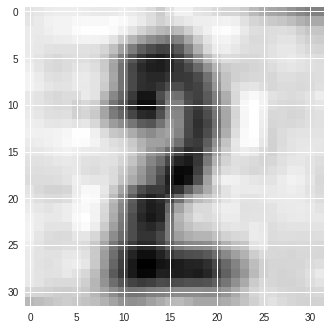

In [0]:
plt.imshow(x_test[2].reshape(32, 32), cmap='gray')

In [0]:
# Predict Scores for each class
prediction = nn.predict_scores(x_test[2])

In [0]:
print "Scores"
print prediction

Scores
[[0.08533674 0.08533674 0.08533674 0.08533674 0.08533674 0.08533674
  0.08533674 0.08533674 0.23196932 0.08533674]]


In [0]:
np.argmax(prediction)

8

In [0]:
predict_class = nn.predict(x_test[2])[0]
predict_class

8

In [0]:
# Original class
y_test[2]

2